TensorFlow version: 2.18.0
Loading datasets...
New Feature Count: 62
Creating Sequences...
Training on 14788 normal sequences.
Epoch 1/40
232/232 ━━━━━━━━━━━━━━━━━━━━ 29s 55ms/step - loss: 0.1947 - val_loss: 0.0488 - learning_rate: 5.0000e-04
Epoch 2/40
232/232 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.0355 - val_loss: 0.0328 - learning_rate: 5.0000e-04
Epoch 3/40
232/232 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0318 - val_loss: 0.0302 - learning_rate: 5.0000e-04
Epoch 4/40
232/232 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0295 - val_loss: 0.0275 - learning_rate: 5.0000e-04
Epoch 5/40
232/232 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.0271 - val_loss: 0.0273 - learning_rate: 5.0000e-04
Epoch 6/40
232/232 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0253 - val_loss: 0.0239 - learning_rate: 5.0000e-04
Epoch 7/40
232/232 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.0239 - val_loss: 0.0240 - learning_rate: 5.0000e-04
Epoch 8/40
232/232 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss:

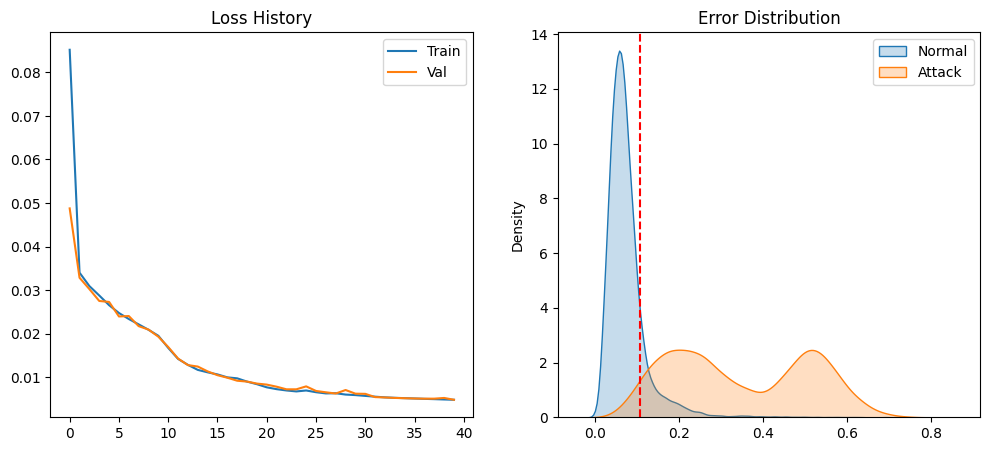

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings

warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)

# ============================================================================
# 1. ADVANCED PREPROCESSING (Log Transform + Top-K Encoding)
# ============================================================================

def handle_categorical_top_k(df, col, k=5):
    """Keep top k categories, label rest as 'other'"""
    top_k = df[col].value_counts().nlargest(k).index
    df[col] = df[col].apply(lambda x: x if x in top_k else 'other')
    return df

def load_and_preprocess_high_acc(train_path, test_path):
    print("Loading datasets...")
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # Drop ID
    for df in [train_df, test_df]:
        if 'id' in df.columns: df.drop('id', axis=1, inplace=True)

    # Combine for consistent encoding
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    full_df = pd.concat([train_df, test_df], axis=0)
    
    # 1. Log Transform Skewed Features (Crucial for Network Data)
    skewed_cols = ['dur', 'sbytes', 'dbytes', 'sload', 'dload', 'spkts', 'dpkts']
    for col in skewed_cols:
        if col in full_df.columns:
            # log1p = log(x + 1) to handle zeros
            full_df[col] = np.log1p(full_df[col])

    # 2. Intelligent Categorical Handling
    cat_cols = ['proto', 'service', 'state']
    for col in cat_cols:
        if col in full_df.columns:
            full_df = handle_categorical_top_k(full_df, col, k=6)
            
    # One-Hot Encoding
    full_df = pd.get_dummies(full_df, columns=cat_cols)
    
    # Clean remaining numeric NaNs
    full_df = full_df.fillna(0)
    
    # Split back
    train_df = full_df[full_df['is_train'] == 1].drop('is_train', axis=1)
    test_df = full_df[full_df['is_train'] == 0].drop('is_train', axis=1)
    
    print(f"New Feature Count: {train_df.shape[1]}")
    return train_df, test_df

# ============================================================================
# 2. SEQUENCE CREATION (Sliding Window)
# ============================================================================

def create_sequences(data, labels, sequence_length=16, stride=2):
    """
    Smaller stride = More training data = Higher Accuracy
    """
    sequences = []
    seq_labels = []
    
    for i in range(0, len(data) - sequence_length + 1, stride):
        seq = data[i:i + sequence_length]
        lbls = labels[i:i + sequence_length]
        
        sequences.append(seq)
        # Strict labeling: If > 30% is attack, it's an attack sequence
        seq_labels.append(1 if np.sum(lbls) > (sequence_length * 0.3) else 0)
        
    return np.array(sequences), np.array(seq_labels)

# ============================================================================
# 3. RESIDUAL CNN-LSTM AUTOENCODER (The Accuracy Booster)
# ============================================================================

def residual_block(x, filters, kernel_size=3):
    """Residual connection to prevent information loss in deep networks"""
    shortcut = x
    
    # First conv
    x = layers.Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Second conv
    x = layers.Conv1D(filters, kernel_size, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    
    # Match dimensions if needed
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding='same')(shortcut)
        
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_high_acc_model(seq_len, n_features, latent_dim=64):
    input_layer = Input(shape=(seq_len, n_features))
    
    # --- Encoder ---
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(input_layer)
    x = residual_block(x, 64)
    x = layers.MaxPooling1D(2)(x) # 16 -> 8
    
    x = residual_block(x, 128)
    x = layers.MaxPooling1D(2)(x) # 8 -> 4
    
    # LSTM Bottleneck
    x = layers.Bidirectional(layers.LSTM(100, return_sequences=False))(x)
    
    # Latent Space
    z = layers.Dense(latent_dim, activation='relu', name='latent_vector')(x)
    
    # --- Decoder ---
    x = layers.RepeatVector(4)(z) # Repeat 4 times
    x = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(x)
    
    # Upsample 4 -> 8
    x = layers.UpSampling1D(2)(x)
    x = residual_block(x, 128)
    
    # Upsample 8 -> 16
    x = layers.UpSampling1D(2)(x)
    x = residual_block(x, 64)
    
    # Final Output
    output_layer = layers.TimeDistributed(layers.Dense(n_features))(x)
    
    return Model(input_layer, output_layer)

# ============================================================================
# 4. HYBRID LOSS & ERROR CALCULATION
# ============================================================================

def calculate_hybrid_error(model, sequences):
    """
    Combines MSE (Magnitude) and Cosine Distance (Direction).
    High accuracy needs to check if the vector points in the wrong direction.
    """
    reconstructed = model.predict(sequences, verbose=0)
    
    # 1. MSE Error
    mse = np.mean(np.square(sequences - reconstructed), axis=(1,2))
    
    # 2. Cosine Similarity (Flatten sequences first)
    seq_flat = sequences.reshape(sequences.shape[0], -1)
    rec_flat = reconstructed.reshape(reconstructed.shape[0], -1)
    
    # Normalize
    seq_norm = np.linalg.norm(seq_flat, axis=1, keepdims=True) + 1e-10
    rec_norm = np.linalg.norm(rec_flat, axis=1, keepdims=True) + 1e-10
    
    dot_product = np.sum(seq_flat * rec_flat, axis=1, keepdims=True)
    cosine_sim = dot_product / (seq_norm * rec_norm)
    cosine_dist = 1 - cosine_sim.flatten()
    
    # Weighted Combination (70% MSE, 30% Direction)
    # Scale MSE to be comparable to Cosine (0-1 range roughly)
    mse_scaled = (mse - np.min(mse)) / (np.max(mse) - np.min(mse) + 1e-10)
    
    total_error = 0.7 * mse_scaled + 0.3 * cosine_dist
    return total_error

# ============================================================================
# 5. MAIN PIPELINE
# ============================================================================

def main():
    # Settings
    SEQ_LEN = 16
    STRIDE = 2 # Lower stride = more data overlap = better learning
    BATCH_SIZE = 64
    EPOCHS = 40 # Enough for early stopping to kick in
    
    # 1. Load & Preprocess
    train_df, test_df = load_and_preprocess_high_acc(
        '/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv',
        '/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv'
    )
    
    # Separate Labels
    X_train = train_df.drop(['label', 'attack_cat'], axis=1, errors='ignore').values
    y_train = train_df['label'].values
    X_test = test_df.drop(['label', 'attack_cat'], axis=1, errors='ignore').values
    y_test = test_df['label'].values
    
    # Scale (MinMax is better for Neural Nets after Log Transform)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # 2. Create Sequences
    print("Creating Sequences...")
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN, STRIDE)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, SEQ_LEN, STRIDE)
    
    # Train only on Normal Traffic
    X_train_normal = X_train_seq[y_train_seq == 0]
    
    # Split Validation
    X_train_split, X_val_split = train_test_split(X_train_normal, test_size=0.2, random_state=42)
    
    print(f"Training on {len(X_train_split)} normal sequences.")
    
    # 3. Build & Train Model
    model = build_high_acc_model(SEQ_LEN, X_train.shape[1])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='mse')
    
    history = model.fit(
        X_train_split, X_train_split,
        validation_data=(X_val_split, X_val_split),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[
            EarlyStopping(patience=5, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=3)
        ],
        verbose=1
    )
    
    # 4. Evaluation with Hybrid Error
    print("\nCalculating Hybrid Reconstruction Errors...")
    train_errors = calculate_hybrid_error(model, X_train_split)
    test_errors = calculate_hybrid_error(model, X_test_seq)
    
    # Determine threshold using Precision-Recall Curve (Best for Imbalanced Data)
    precision, recall, thresholds = precision_recall_curve(y_test_seq, test_errors)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    
    print(f"Optimal Threshold: {optimal_threshold:.5f}")
    
    # Predictions
    y_pred = (test_errors > optimal_threshold).astype(int)
    
    # Results
    print("\n" + "="*50)
    print("FINAL HIGH-ACCURACY RESULTS")
    print("="*50)
    print(classification_report(y_test_seq, y_pred, target_names=['Normal', 'Attack']))
    print(f"ROC-AUC Score: {roc_auc_score(y_test_seq, test_errors):.4f}")
    
    # Visuals
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss History')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.kdeplot(test_errors[y_test_seq==0], label='Normal', fill=True)
    sns.kdeplot(test_errors[y_test_seq==1], label='Attack', fill=True)
    plt.axvline(optimal_threshold, color='red', linestyle='--')
    plt.title('Error Distribution')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()